# Population Collapse Importance Factor

In [13]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
import category_encoders as ce
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# Data preparation

In [14]:
data0 = pd.read_csv("/kaggle/input/population-collapse/all_indicators.csv")
display(data0)
print(data0.columns.tolist())
data0=data0.dropna().reset_index(drop=True)
display(data0.info())

,economy,Pop-YR2002,Pop-YR2021,Pop%,Life-YR2002,Life-YR2021,Life%,Fer-YR2002,Fer-YR2021,Fer%,...,Death-YR2021,Death%,Birth-YR2002,Birth-YR2021,Birth%,Med_Age-YR2002,Med_Age-YR2021,Med%,Pop_Gro-YR2002,Pop_Gro-YR2021
0,ABW,91781,106537,0.160774,73.726000,74.626000,0.012207,1.763000,1.180000,-0.330686,...,11.235000,0.750000,12.992000,7.193000,-0.446352,33.9,41.2,0.215339,1.194718,-0.045045
1,AFE,422741118,702977106,0.662902,52.540794,62.454590,0.188688,5.430475,4.354709,-0.198098,...,8.036899,-0.396157,40.047325,33.546266,-0.162334,NaN,NaN,NaN,2.606598,2.607472
2,AFG,21000256,40099462,0.909475,56.454000,61.982000,0.097920,7.339000,4.643000,-0.367353,...,7.344000,-0.348936,48.201000,35.842000,-0.256405,14.0,16.7,0.192857,6.449321,2.851358
3,AFW,284952322,478185907,0.678126,50.927848,56.988657,0.119008,5.967267,4.978662,-0.165671,...,10.678952,-0.288397,42.927121,36.237034,-0.155848,NaN,NaN,NaN,2.811453,2.573377
4,AGO,17516139,34503774,0.969828,47.386000,61.643000,0.300869,6.567000,5.304000,-0.192325,...,8.009000,-0.536382,47.448000,38.809000,-0.182073,15.7,16.2,0.031847,3.335132,3.166030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,XKX,1702310,1786038,0.049185,74.676000,76.806000,0.028523,2.533000,1.522000,-0.399131,...,7.220000,0.439968,16.858000,11.143000,-0.339008,21.5,30.5,0.418605,0.067931,-0.229016
262,YEM,19660653,32981641,0.677546,63.906000,63.753000,-0.002394,5.937000,3.795000,-0.360788,...,6.845000,-0.049702,38.654000,30.544000,-0.209810,14.6,18.7,0.280822,2.665834,2.137790
263,ZAF,47661514,59392255,0.246126,55.666000,62.341000,0.119912,2.324000,2.374000,0.021515,...,11.432000,-0.029871,20.040000,19.821000,-0.010928,21.5,27.1,0.260465,0.910101,0.998920
264,ZMB,10508294,19473125,0.853120,46.979000,61.223000,0.303199,5.792000,4.308000,-0.256215,...,6.973000,-0.544010,44.746000,34.511000,-0.228736,14.8,16.9,0.141892,3.056528,2.840806


['economy', 'Pop-YR2002', 'Pop-YR2021', 'Pop%', 'Life-YR2002', 'Life-YR2021', 'Life%', 'Fer-YR2002', 'Fer-YR2021', 'Fer%', 'Death-YR2002', 'Death-YR2021', 'Death%', 'Birth-YR2002', 'Birth-YR2021', 'Birth%', 'Med_Age-YR2002', 'Med_Age-YR2021', 'Med%', 'Pop_Gro-YR2002', 'Pop_Gro-YR2021']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   economy         216 non-null    object 
 1   Pop-YR2002      216 non-null    int64  
 2   Pop-YR2021      216 non-null    int64  
 3   Pop%            216 non-null    float64
 4   Life-YR2002     216 non-null    float64
 5   Life-YR2021     216 non-null    float64
 6   Life%           216 non-null    float64
 7   Fer-YR2002      216 non-null    float64
 8   Fer-YR2021      216 non-null    float64
 9   Fer%            216 non-null    float64
 10  Death-YR2002    216 non-null    float64
 11  Death-YR2021    21

None

In [15]:
idx2eco = data0['economy'].to_dict()
#print(idx2eco)
eco2idx = {v: k for k, v in idx2eco.items()}
print(eco2idx)

{'ABW': 0, 'AFG': 1, 'AGO': 2, 'ALB': 3, 'ARE': 4, 'ARG': 5, 'ARM': 6, 'ATG': 7, 'AUS': 8, 'AUT': 9, 'AZE': 10, 'BDI': 11, 'BEL': 12, 'BEN': 13, 'BFA': 14, 'BGD': 15, 'BGR': 16, 'BHR': 17, 'BHS': 18, 'BIH': 19, 'BLR': 20, 'BLZ': 21, 'BMU': 22, 'BOL': 23, 'BRA': 24, 'BRB': 25, 'BRN': 26, 'BTN': 27, 'BWA': 28, 'CAF': 29, 'CAN': 30, 'CHE': 31, 'CHL': 32, 'CHN': 33, 'CIV': 34, 'CMR': 35, 'COD': 36, 'COG': 37, 'COL': 38, 'COM': 39, 'CPV': 40, 'CRI': 41, 'CUB': 42, 'CUW': 43, 'CYP': 44, 'CZE': 45, 'DEU': 46, 'DJI': 47, 'DMA': 48, 'DNK': 49, 'DOM': 50, 'DZA': 51, 'ECU': 52, 'EGY': 53, 'ERI': 54, 'ESP': 55, 'EST': 56, 'ETH': 57, 'FIN': 58, 'FJI': 59, 'FRA': 60, 'FRO': 61, 'FSM': 62, 'GAB': 63, 'GBR': 64, 'GEO': 65, 'GHA': 66, 'GIB': 67, 'GIN': 68, 'GMB': 69, 'GNB': 70, 'GNQ': 71, 'GRC': 72, 'GRD': 73, 'GRL': 74, 'GTM': 75, 'GUM': 76, 'GUY': 77, 'HIC': 78, 'HKG': 79, 'HND': 80, 'HRV': 81, 'HTI': 82, 'HUN': 83, 'IDN': 84, 'IMN': 85, 'IND': 86, 'IRL': 87, 'IRN': 88, 'IRQ': 89, 'ISL': 90, 'ISR': 9

In [16]:
from sklearn.preprocessing import LabelEncoder

def labelencoder(df):
    for c in df.columns:
        if df[c].dtype=='object': 
            df[c] = df[c].fillna('N')
            lbl = LabelEncoder()
            lbl.fit(list(df[c].values))
            df[c] = lbl.transform(df[c].values)
    return df

In [17]:
data1=labelencoder(data0.copy())

# Target setting

In [18]:
target=['Pop%']
trainY=data1[target]
trainX=data1.drop([target[0]],axis=1)

train_df=trainX
df_columns=train_df.columns.tolist()

In [19]:
#train_df.columns=df_columns
#test_df.columns=df_columns

In [20]:
def create_numeric_feature(input_df):
    use_columns = df_columns 
    return input_df[use_columns].copy()

In [21]:
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [22]:
from tqdm import tqdm

def to_feature(input_df):

    processors = [
        create_numeric_feature,
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [23]:
train_feat_df = to_feature(train_df)
#test_feat_df = to_feature(test_df)

100%|██████████| 1/1 [00:00<00:00, 358.27it/s]

createcreate_numeric_feature  0.002[s]


# Model

In [24]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, y, cv, 
             params: dict=None, 
             verbose: int=50):

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')
        print()

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [25]:
params = {
    'objective': 'rmse', 
    'learning_rate': .1,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5, 
    'n_estimators': 10000, 
    'colsample_bytree': .5, 
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain', 
    'random_state': 71,
    'num_leaves': 62
}

In [26]:
y = trainY
ydf=pd.DataFrame(y)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 0.142615
fit fold=0  0.094[s]
Fold 0 RMSLE: 0.1426

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[264]	valid_0's rmse: 0.163735
fit fold=1  0.156[s]
Fold 1 RMSLE: 0.1637

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	valid_0's rmse: 0.109162
fit fold=2  0.061[s]
Fold 2 RMSLE: 0.1092

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[98]	valid_0's rmse: 0.108494
fit fold=3  0.068[s]
Fold 3 RMSLE: 0.1085

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.254408
Early stopping, best iteration is:
[418]	valid_0's rmse: 0.254403
fit fold=4  0.151[s]
Fold 4 RMSLE: 0.2544

--------------------------------------------------
FINISHED | Whole RMSLE: 0.1646


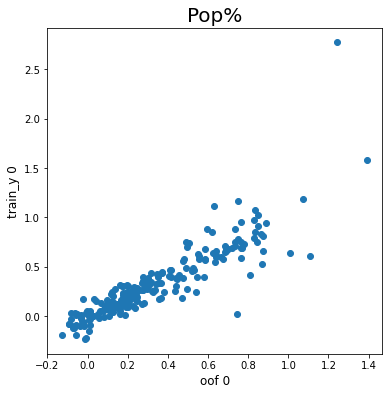

In [27]:
from sklearn.model_selection import KFold

for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    
    fig,ax = plt.subplots(figsize=(6,6))
    ax.set_title(target[i],fontsize=20)
    ax.set_xlabel('oof '+str(i),fontsize=12)
    ax.set_ylabel('train_y '+str(i),fontsize=12)
    ax.scatter(oof,y)


# Visualize Importance

In [28]:
def visualize_importance(models, feat_train_df):

    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]
    print(list(order)[0:10])

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    
    ax.tick_params(axis='x', rotation=0)
    #ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig,ax

#fig, ax = visualize_importance(models, train_feat_df)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 0.142615
fit fold=0  0.050[s]
Fold 0 RMSLE: 0.1426

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[264]	valid_0's rmse: 0.163735
fit fold=1  0.115[s]
Fold 1 RMSLE: 0.1637

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	valid_0's rmse: 0.109162
fit fold=2  0.058[s]
Fold 2 RMSLE: 0.1092

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[98]	valid_0's rmse: 0.108494
fit fold=3  0.065[s]
Fold 3 RMSLE: 0.1085

Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 0.254408
Early stopping, best iteration is:
[418]	valid_0's rmse: 0.254403
fit fold=4  0.157[s]
Fold 4 RMSLE: 0.2544

--------------------------------------------------
FINISHED | Whole RMSLE: 0.1646
['Pop_Gro-YR2002', 'Pop_Gro-YR2021'

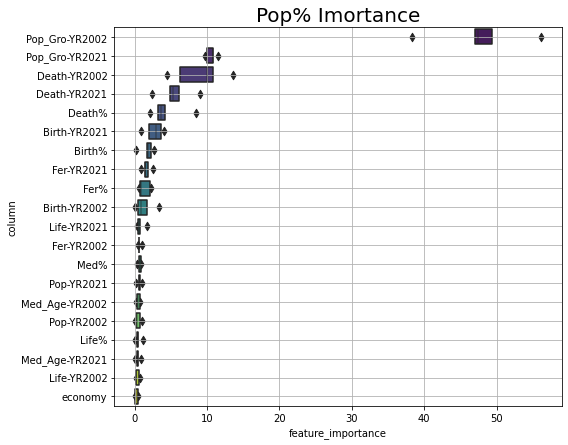

In [29]:
for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    fig, ax = visualize_importance(models, train_feat_df)
    ax.set_title(target[i]+' Imortance',fontsize=20)

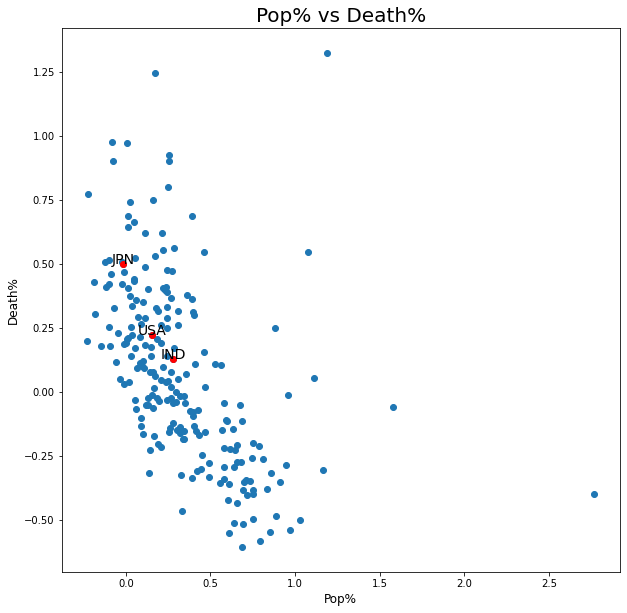

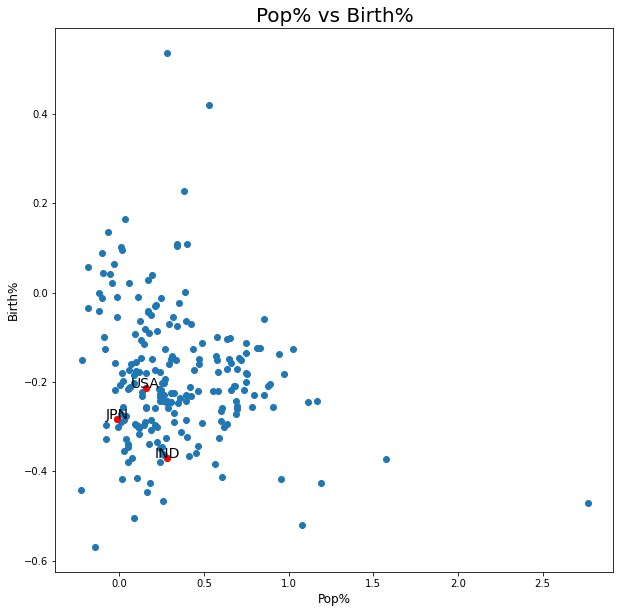

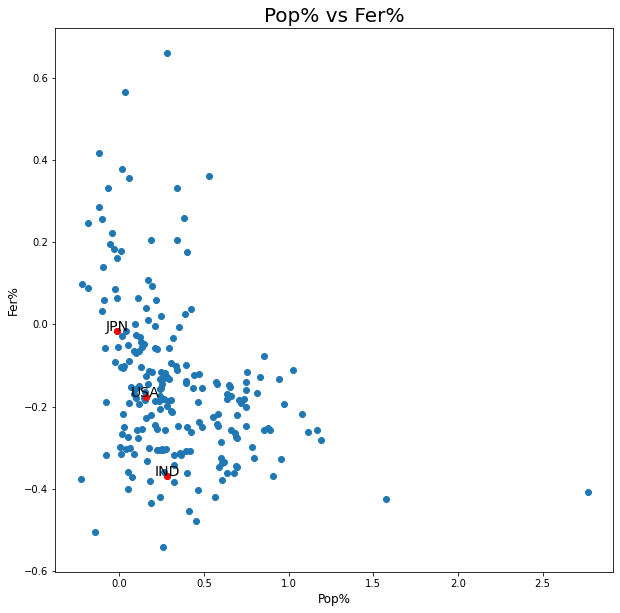

In [30]:
cols=['Death%','Birth%','Fer%']
for col in cols:
    fig,ax = plt.subplots(figsize=(10,10))
    ax.set_title('Pop% vs '+col,fontsize=20)
    ax.set_xlabel('Pop%',fontsize=12)
    ax.set_ylabel(col,fontsize=12)
    ax.scatter(data0['Pop%'],data0[col])
    
    for eco in ['USA','JPN','IND']:
        point_index = eco2idx[eco]
        text_x = data0['Pop%'].iloc[point_index]
        text_y = data0[col].iloc[point_index] 
        text = data0['economy'].iloc[point_index]  
        ax.text(text_x, text_y, text, fontsize=14, ha='center')
        
        x = data0['Pop%'].iloc[point_index]
        y = data0[col].iloc[point_index]
        ax.scatter(x, y, c='red', label=eco)
        
    plt.show()